In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
from matplotlib import pyplot as plt
from PIL import Image
#from joblib import Parallel, delayed  #multithreading 

In [3]:
# Definir una red neuronal simple
class Model_qm(nn.Module):
    def __init__(self):
        super(Model_qm, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [4]:
q_m_XOR = Model_qm()
state_dict_XOR = torch.load('q_m_XOR.pth')
q_m_XOR.load_state_dict(state_dict_XOR)
#input must be tensor with float (each bit)
def q_m_XOR_diff(bits):
    return q_m_XOR(bits)

In [5]:
q_m_XNOR = Model_qm()
state_dict_XNOR = torch.load('q_m_XNOR.pth')
q_m_XNOR.load_state_dict(state_dict_XNOR)
#input must be tensor with float (each bit)
def q_m_XNOR_diff(bits):
    return q_m_XNOR(bits)

In [6]:
#input must be float (each bit)
def q_m_diff(input):
    output = torch.tensor([input[0], 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32)
    num_1 = torch.sum(input > 0.5)
    if (num_1 > 4) or (num_1 == 4 and input[0] == 0):
        output[:8] = q_m_XNOR_diff(input)
        output[8] = 0
    else:
        output[:8] = q_m_XOR_diff(input)
        output[8] = 1
    return output

In [7]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    bits_inversos = torch.flip(pixel_bits, dims = (0,))
    q_m = q_m_diff(bits_inversos)
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float32)
    num_1 = torch.sum(q_m[:8] > 0.5)
    num_0 = torch.sum(q_m[:8] < 0.5)
    IndE = cnt == 0 or (num_1 == num_0)
    IndC = (cnt > 0 and (num_1 > num_0)) or (cnt < 0 and (num_0 > num_1))
    Neg_q = 1 - q_m

    if (IndE and q_m[8] > 0.5) or (not(IndC) and not(IndE)):
        output[:8] = q_m[:8]
    else:
        output[:8] = Neg_q[:8]
    output[8] = q_m[8]
    if IndE:
        output[9] = Neg_q[8]
        if q_m[8] < 0.5:
            new_cnt = cnt + num_0 - num_1
        else:
            new_cnt = cnt + num_1 - num_0
    else:
        if IndC:
            output[9] = 1
            new_cnt = cnt + 2 * q_m[8] + num_0 - num_1
        else:
            output[9] = 0
            new_cnt = cnt - 2 * Neg_q[8] + num_1 - num_0
    return output,new_cnt

In [8]:
def sigmoid(x):
    x_in = x.clone()
    if x >= 0:
        return 1 / (1 + torch.exp(-x_in))
    else:
        return torch.exp(x_in) / (1 + torch.exp(x_in))

def Pixel2Bit_diff(pixel):
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype= torch.float32)
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output

In [9]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 1

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)
    g_t = signal.decimate(g_t,q = muestras_por_pulso)

    # si armonico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:100]
    else:
        g_t = g_t[:200]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64).reshape(1,1,len(g_t))

In [15]:
def TMDS_rows(img,columnas,g_t,padding):
    cnt = 0
    bits_cod_fila =  torch.zeros((1,1,10*columnas), dtype = torch.complex64)
    for j in range(columnas):
        pixel = img[j]
        pixel_bits = Pixel2Bit_diff(pixel)
        pixel_cod,cnt = TMDS_diff(pixel_bits, cnt)
        bits_cod_fila[0,0,j*10:(j+1)*10] = pixel_cod
    img_block = nn.functional.conv1d(bits_cod_fila, g_t, stride = 10, padding=padding, bias = None)[0,0,:].reshape(columnas)
    img_block.backward(gradient=torch.ones_like(img_block),retain_graph = False)
    grad_fila = img.grad
    return img_block,grad_fila

In [18]:
def forward(img, armonico):
    filas, columnas = img.shape
    g_t = g_taps(filas, columnas, armonico)
    size_g_t = g_t.numel()    
    padding = (size_g_t - 10)//2
    grads = []
    for i in range(filas):
        img_slice = torch.tensor(img[i,:], dtype=torch.float32, requires_grad=True)
        img_fila,grad = TMDS_rows(img_slice,columnas,g_t,padding)
        if i == 0:
            img_salida = img_fila.detach()
        else:
            img_salida = torch.cat((img_salida, img_fila.detach()), dim = 0)
        grads.append(grad.detach())
        del grad
        del img_fila
        del img_slice
    img_salida = img_salida.reshape((filas,columnas))
    return img_salida,grads

In [19]:
image_path = '../../images/VAMO!!.png'
img = np.zeros((250,250))
#img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
armonico = 3
imagen,grads = forward(img, armonico)

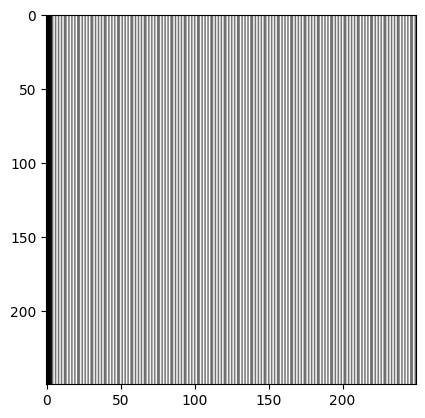

In [20]:
img_sim = np.abs(imagen.detach().numpy())
plt.figure()
plt.imshow(255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.show()